In [82]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import re
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# My attempt on titnaic problem from Kaggle
# https://www.kaggle.com/competitions/titanic/overview
# with minimal/occaasional reference from:
# https://www.kaggle.com/code/startupsci/titanic-data-science-solutions
# https://www.analyticsvidhya.com/blog/2021/10/implementing-artificial-neural-networkclassification-in-python-from-scratch/
#
# Code to predict who survived in titanic sinking


In [2]:
#Get Data
train_dataset = pd.read_csv("./train.csv", na_values='?', comment='\t', sep=',', skipinitialspace=True)
test_dataset = pd.read_csv("./test.csv", na_values='?', comment='\t', sep=',', skipinitialspace=True)

#Check Columns/Features
print(train_dataset.columns.values)
print(test_dataset.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


In [3]:
train_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Check info, eg. which have NaN (In this case Age, Cabin, Embarked)
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test_dataset.info() 
#Age, Fare, Cabin


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
train_dataset.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [245]:
#Data "cleaning"(?) 
# Get new data from existing data 
# fill NaN data

#GET DATA AGAIN lol
train_dataset = pd.read_csv("./train.csv", na_values='?', comment='\t', sep=',', skipinitialspace=True)
test_dataset = pd.read_csv("./test.csv", na_values='?', comment='\t', sep=',', skipinitialspace=True)

combine = [train_dataset,test_dataset]

for dataset in combine:
    #Family Size
    dataset["FamSize"]=dataset["SibSp"]+dataset["Parch"]
    
    #Alone or not
    dataset["Alone"] =  (dataset["FamSize"]  == 0)

    #Fill in the blanks
    dataset["Age"] = dataset["Age"].fillna(value=-1)
    dataset["Embarked"] = dataset["Embarked"].fillna(value="-")
    dataset["Fare"] = dataset["Fare"].fillna(value=-1)
    dataset["Cabin"] =  dataset["Cabin"].fillna(value=0)
    
    # Update Cabin Data
    dataset["CabinGroup"] = dataset["Cabin"].str.replace('\d+', '')
    #print(dataset["CabinGroup"].unique())
#    Cabingroup = ["A", "B", "C", "D", "E", "F", "G", "T"]
#    for i in Cabingroup:
#        dataset[i] =     dataset["CabinGroup"].str.count(i)
#        dataset[i] =     dataset[i].fillna(value=0)
#        #print(dataset[[i, "Survived"]].groupby([i], as_index=False).mean().sort_values(by='Survived', ascending=False))
    
    #Number of Cabin
    dataset["NumOfCabin"] = dataset["CabinGroup"].str.split(" ").str.len()
    dataset["NumOfCabin"] = dataset["NumOfCabin"].fillna(value=0)

    #Ticket Number
    dataset['TicketNum']= dataset["Ticket"].str.split(" ").str[-1]
    dataset ['TicketNum'] = pd.to_numeric(dataset['TicketNum'], errors='coerce')
    dataset ['TicketNum'] = dataset['TicketNum'].replace(np.nan, -1, regex=True)

    #Name
    dataset["First Name"] = dataset['Name'].str.split(",").str[0]
    dataset["Last Name"] = dataset['Name'].str.split(",").str[-1].str.split(".").str[-1].str.split(" ").str[-1]
    #dataset.loc[dataset['Name'].str.split(",").str.len() == 2, 'Last Name'] = dataset['Name'].str.split(",").str[-1].str.split(".").str[-1]
    

    #Title
    dataset.loc[dataset['Name'].str.split(",").str.len() == 2, 'Title'] = dataset['Name'].str.split(",").str[-1].str.split(".").str[0]
    dataset["Title"] = dataset["Title"].replace(" Ms", " Miss")
    dataset['Title'] = dataset['Title'].replace([' Lady', ' Countess',' Capt', ' Col', 	' Don', ' Dr', ' Major', ' Rev', ' Sir', ' Jonkheer', ' Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

/tmp/ipykernel_514997/791179808.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["CabinGroup"] = dataset["Cabin"].str.replace('\d+', '')
/tmp/ipykernel_514997/791179808.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["CabinGroup"] = dataset["Cabin"].str.replace('\d+', '')


In [219]:
train_dataset = train_dataset.drop(["Name","First Name","Last Name","Cabin","CabinGroup","Ticket","PassengerId"],axis=1)
test_dataset = test_dataset.drop(["Name","First Name","Last Name","Cabin","CabinGroup","Ticket","PassengerId"],axis=1)
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked    891 non-null    object 
 8   FamSize     891 non-null    int64  
 9   Alone       891 non-null    bool   
 10  NumOfCabin  891 non-null    float64
 11  TicketNum   891 non-null    float64
 12  Title       891 non-null    object 
dtypes: bool(1), float64(4), int64(5), object(3)
memory usage: 84.5+ KB


In [8]:

##Try to see any correlation with the initials and survival rate


#train_dataset["F"] =  train_dataset['First Name'].str[0].sort_values().reset_index(drop=True)
#train_dataset["L"] =  train_dataset['Last Name'].str[0].sort_values().reset_index(drop=True)
#with pd.option_context('display.max_rows', None,):
#   print(train_dataset[['F', "Survived"]].groupby(["F"], as_index=False).mean().sort_values(by='Survived', ascending=False).head(100))
#   print(train_dataset[['L', "Survived"]].groupby(["L"], as_index=False).mean().sort_values(by='Survived', ascending=False).head(100))
#
#g = sns.FacetGrid(train_dataset,col="Survived",size=10)
#g.map(sns.histplot, "L")
#plt.show()
#
#g = sns.FacetGrid(train_dataset,col="Survived",size=10)
#g.map(sns.histplot, "F")
#plt.show()


##-> not really, only see how common names are generally


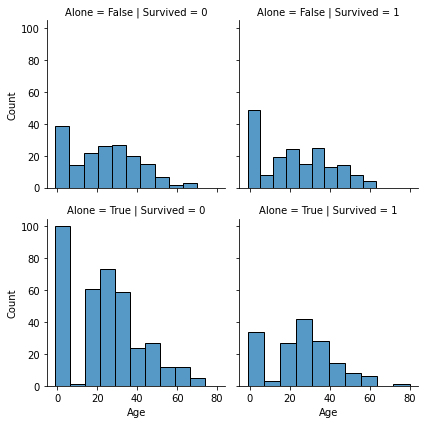

In [28]:

g = sns.FacetGrid(train_dataset, col='Survived',row='Alone')
g.map(sns.histplot, "Age",bins=10)
plt.show()

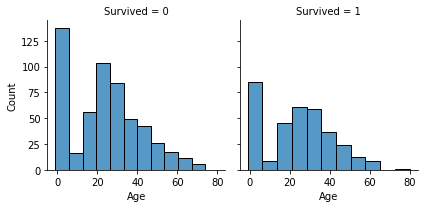

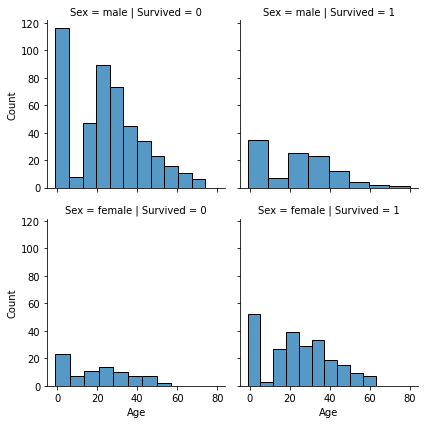

In [29]:
#Visualize some data to get some idea
g = sns.FacetGrid(train_dataset, col='Survived')
g.map(sns.histplot, "Age")
plt.show()

g = sns.FacetGrid(train_dataset, col='Survived',row='Sex')
g.map(sns.histplot, "Age")
plt.show()

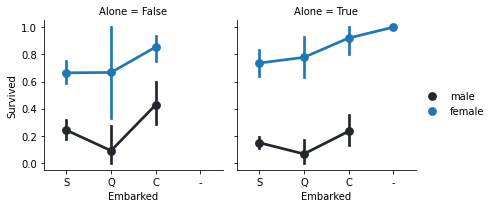

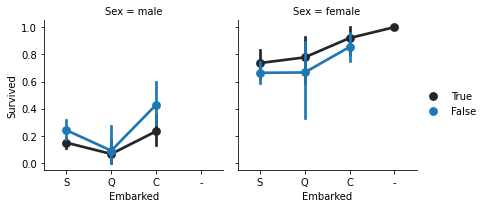

In [30]:
g = sns.FacetGrid(train_dataset, col="Alone")
g.map(sns.pointplot, 'Embarked',"Survived", "Sex", order=["S","Q","C","-"],hue_order=["male","female"])
g.add_legend()
plt.show()

g = sns.FacetGrid(train_dataset, col="Sex")
g.map(sns.pointplot, 'Embarked',"Survived", "Alone", order=["S","Q","C","-"],hue_order=[True,False])
g.add_legend()
plt.show()
#Somehow if youre a man and youre alone, you die more easily
#but if youre a woman and youre alone, you more likely to survived?


/home/ys/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


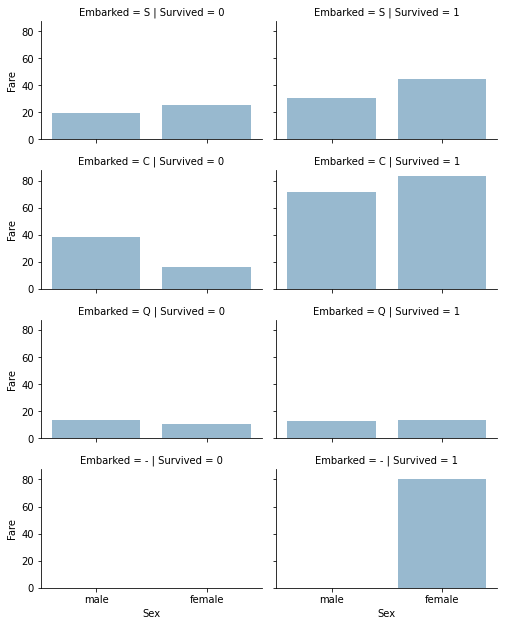

In [31]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_dataset, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None,order=["male","female"])
grid.add_legend()

In [246]:
train_dataset = train_dataset.drop(["Name","First Name","Last Name","Cabin","CabinGroup","Ticket","Fare","TicketNum","PassengerId"],axis=1)
test_dataset = test_dataset.drop(["Name","First Name","Last Name","Cabin","CabinGroup","Ticket","Fare","TicketNum","PassengerId"],axis=1)

In [247]:
train_dataset_train = train_dataset.sample(frac=0.8)
train_dataset_test = train_dataset.drop(train_dataset_train.index)

train_features = train_dataset_train.drop(["Survived"],axis=1)
train_target = train_dataset_train["Survived"]

test_features = train_dataset_test.drop(["Survived"],axis=1)
test_target = train_dataset_test["Survived"]

train_features.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 713 entries, 624 to 163
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      713 non-null    int64  
 1   Sex         713 non-null    object 
 2   Age         713 non-null    float64
 3   SibSp       713 non-null    int64  
 4   Parch       713 non-null    int64  
 5   Embarked    713 non-null    object 
 6   FamSize     713 non-null    int64  
 7   Alone       713 non-null    bool   
 8   NumOfCabin  713 non-null    float64
 9   Title       713 non-null    object 
dtypes: bool(1), float64(2), int64(4), object(3)
memory usage: 56.4+ KB


In [248]:

#ct = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [2,7,9,20])], remainder='passthrough')
#train_dataset = ct.fit_transform(train_dataset)
#print(train_dataset[0])

ct =ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[1,5,9])],remainder="passthrough")
X = np.array(ct.fit_transform(train_features))
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X)
#X_test = sc.transform(test_dataset)

ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=20,activation="relu"))
ann.add(tf.keras.layers.Dense(units=10,activation="relu"))
ann.add(tf.keras.layers.Dropout(.05))#, input_shape=(32,)
ann.add(tf.keras.layers.Dense(units=5,activation="relu"))
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])

history = ann.fit(X_train,train_target,batch_size=32,epochs = 500,shuffle=True,validation_split=0.2)



Epoch 1/500
18/18 [==============================] - 1s 9ms/step - loss: 0.7956 - accuracy: 0.6228 - val_loss: 0.7236 - val_accuracy: 0.6573
Epoch 2/500
18/18 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.6404 - val_loss: 0.6399 - val_accuracy: 0.6993
Epoch 3/500
18/18 [==============================] - 0s 4ms/step - loss: 0.5981 - accuracy: 0.6877 - val_loss: 0.5788 - val_accuracy: 0.7692
Epoch 4/500
18/18 [==============================] - 0s 4ms/step - loss: 0.5439 - accuracy: 0.7246 - val_loss: 0.5380 - val_accuracy: 0.7692
Epoch 5/500
18/18 [==============================] - 0s 4ms/step - loss: 0.4993 - accuracy: 0.7684 - val_loss: 0.5118 - val_accuracy: 0.7972
Epoch 6/500
18/18 [==============================] - 0s 4ms/step - loss: 0.4686 - accuracy: 0.7754 - val_loss: 0.4956 - val_accuracy: 0.8042
Epoch 7/500
18/18 [==============================] - 0s 4ms/step - loss: 0.4610 - accuracy: 0.7877 - val_loss: 0.4838 - val_accuracy: 0.8042
Epoch 8/500
1

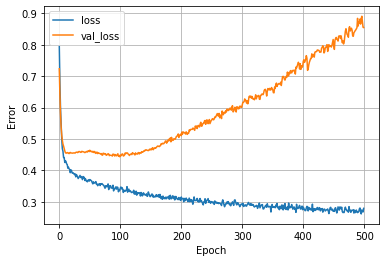

In [249]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 0.0050])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  #plt.yscale('log')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [204]:
X_test = sc.fit_transform(np.array(ct.fit_transform(test_features)))
print(ann.predict(sc.fit_transform([X_test[10]])),test_target.iloc[0:10])
ann.predict(X_test).round(2)


[[0.02614516]] 3     1
8     1
15    1
16    0
19    1
20    0
24    0
25    1
27    0
30    0
Name: Survived, dtype: int64


array([[1.  ],
       [0.  ],
       [0.9 ],
       [0.  ],
       [0.87],
       [0.9 ],
       [0.  ],
       [0.  ],
       [1.  ],
       [1.  ],
       [1.  ],
       [1.  ],
       [0.01],
       [0.89],
       [0.13],
       [0.08],
       [0.  ],
       [0.  ],
       [1.  ],
       [1.  ],
       [0.72],
       [0.02],
       [0.13],
       [0.26],
       [0.  ],
       [0.  ],
       [1.  ],
       [0.  ],
       [0.12],
       [0.18],
       [0.01],
       [1.  ],
       [0.  ],
       [0.23],
       [0.98],
       [0.94],
       [1.  ],
       [0.  ],
       [0.  ],
       [0.11],
       [0.4 ],
       [0.  ],
       [0.8 ],
       [0.02],
       [1.  ],
       [0.22],
       [0.  ],
       [1.  ],
       [0.  ],
       [0.99],
       [0.02],
       [0.13],
       [0.97],
       [1.  ],
       [0.99],
       [0.05],
       [1.  ],
       [0.  ],
       [1.  ],
       [0.9 ],
       [0.23],
       [0.97],
       [0.02],
       [0.95],
       [0.  ],
       [0.  ],
       [0.

In [84]:
print(len(train_features.columns))
encoder = LabelEncoder()
encoder.fit(train_target)
encoded_Y = encoder.transform(train_target)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(20, input_dim=20, activation='relu'))
	model.add(Dense(10, activation='relu'))
	model.add(Dense(6, activation='relu'))
	model.add(Dense(2, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)

kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, train_features, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

20


/tmp/ipykernel_514997/4151315782.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)


Baseline: nan% (nan%)


/home/ys/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ys/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ys/.local/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/ys/.local/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_arg

In [69]:
train_dataset.describe().transpose()[['mean', 'std']]
normalizer = preprocessing.Normalization(axis=1)
print(np.array(train_features.columns))
normalizer.adapt(train_features)

#ct = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [2,7,9,20])], remainder='passthrough')
#train_dataset = ct.fit_transform(train_dataset)
#print(train_dataset[0])


['Pclass' 'Sex' 'Age' 'SibSp' 'Parch' 'Fare' 'Embarked' 'FamSize' 'Alone'
 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'T' 'NumOfCabin' 'TicketNum' 'Title']


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [34]:
ann = tf.models.Sequential()
ann.add(tf.layers.Dense(units=6, activation='relu'))
ann.add(tf.layers.Dense(units=8, activation='relu'))
ann.add(tf.layers.Dense(units=6, activation='relu'))

AttributeError: module 'tensorflow' has no attribute 'models'

In [19]:
normalizer = preprocessing.Normalization(axis=1)
normalizer.adapt(np.array(["PassengerId","Survived","Pclass","Name","Sex","Age","SibSp","Parch","Ticket","Fare","Cabin","Embarked"]))

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
train_dataset.head(100)
#test_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0,3,"Shorney, Mr. Charles Joseph",male,NaN,0,0,374910,8.0500,NaN,S
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C
98,99,1,2,"Doling, Mrs. John T (Ada Julia Bone)",female,34.0,0,1,231919,23.0000,NaN,S
